In [300]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, KMeans
from scipy.spatial.distance import pdist, squareform, cdist
from datetime import datetime
from ceto.analysis import frechet_distance, douglas_peucker, haversine
import folium
from scipy.optimize import minimize
import random
from typing import List, Tuple
import pydeck as pdk
from copy import deepcopy
import time
from scipy.interpolate import interp1d
from collections import Counter

In [519]:
def cluster_paths(paths: List[List[Tuple[float, float]]], alpha: float = 0.3, eps: float = 100, min_samples: int = 2, epsilon: float = 10) -> List[int]:
    """
    Cluster paths using the Fréchet distance and DBSCAN.
    """

    # Simplify the paths
    simplified_paths = [douglas_peucker(path, epsilon) for path in paths]

    # Compute path directions
    path_directions = [np.arctan2(path[-1][1] - path[0][1], path[-1][0] - path[0][0]) for path in simplified_paths]

    
    # Compute pairwise distances between all pairs of trajectories using the Fréchet distance
    distance_matrix = np.zeros([len(simplified_paths), len(simplified_paths)])
    for i, i_path in enumerate(simplified_paths):
        for j, j_path in enumerate(simplified_paths):
            if i == j:
                distance_matrix[i,j] = 0
            else:
                fr_dist = frechet_distance(i_path, j_path)
                angular_diff = angular_diff = np.abs(path_directions[i] - path_directions[j])
                distance_matrix[i, j] = (1 - alpha) * fr_dist + alpha * angular_diff
    
    # Apply DBSCAN clustering to group similar trajectories together
    clustering = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
    labels = clustering.fit_predict(distance_matrix)
    
    return labels


COLORS = [
    (31, 119, 180), (255, 127, 14), (44, 160, 44), (214, 39, 40), (148, 103, 189), (140, 86, 75),
    (227, 119, 194), (127, 127, 127), (188, 189, 34), (23, 190, 207), (230, 25, 75), (60, 180, 75),
    (245, 130, 49), (145, 30, 180), (70, 240, 240), (240, 50, 230), (188, 246, 12), (250, 190, 190),
    (0, 128, 128), (230, 190, 255), (154, 99, 36), (255, 250, 200), (128, 0, 0), (170, 255, 195),
    (128, 128, 0), (255, 216, 177), (0, 0, 128), (169, 169, 169), (255, 255, 255), (0, 0, 0)
]

def get_cluster_colors(labels):
    return [COLORS[label] if label != -1 else [255.0,255.0,255.0] for label in labels]

def to_pydeck(trips, start_unix_time=None, colors=None):
    pdk_trips = deepcopy(trips)

    if colors is None:
        colors = [[333,33,33]]*len(trips)

    for pdk_trip, color in zip(pdk_trips, colors):
        # Lat, lon to lon, lat
        pdk_trip["path"] = [[p[1],p[0]] for p in pdk_trip["path"]]

        # relative_timestamap
        if "timestamp" in pdk_trip:
            t0 = start_unix_time if start_unix_time is not None else pdk_trips[0]["timestamp"][0]
            pdk_trip["relative_timestamp"] = [ts - t0 for ts in pdk_trip["timestamp"]]

        pdk_trip["color"] = color
    return pdk_trips

def generate_representative_path(paths: List[List[Tuple[float, float]]], epsilon: float = 10) -> List[Tuple[float, float]]:
    
    # Find the representative waypoints. 
    s_paths = [douglas_peucker(path, epsilon) for path in paths]
    average_length = int(sum([len(s_path) for s_path in s_paths])/len(s_paths))
    kmeans = KMeans(n_clusters=average_length, random_state=0, n_init="auto")
    points = [point for sublist in s_paths for point in sublist]
    kmeans.fit_predict(points)
    cluster_centers = [(p[0],p[1]) for p in kmeans.cluster_centers_]

    # Reorder the cluster centers based on the order of points in each path separately
    ordered_cluster_centers_per_path = []
    for path in s_paths:
        ordered_path = sorted(cluster_centers, key=lambda x: path.index(min(path, key=lambda p: (x[0] - p[0])**2 + (x[1] - p[1])**2)))
        ordered_cluster_centers_per_path.append(ordered_path)

    # Find the most common order among the ordered_cluster_centers_per_path
    orders_count = Counter(tuple(order) for order in ordered_cluster_centers_per_path)
    most_common_order = orders_count.most_common(1)[0][0]
    
    return most_common_order


In [ ]:

# Generate a histogram of the total fuel consumption for each trajectory cluster
def fuel_consumption_histogram(trajectories, labels):
    n_clusters = len(set(labels))
    fuel_consumption = [0] * n_clusters

    for traj, label in zip(trajectories, labels):
        fuel_consumption[label] += sum(point[2] for point in traj)

    # Plot the histogram
    plt.bar(range(n_clusters), fuel_consumption)
    plt.xlabel('Cluster')
    plt.ylabel('Total Fuel Consumption')
    plt.title('Fuel Consumption per Trajectory Cluster')
    plt.show()


In [260]:
# Parameters
file_path = 'data/2022-11-20 - Djurga╠èrden 11 2 dagar mer vind.csv'
stop_duration = 0.5  # minutes 
speed_threshold = 2 # knots
epsilon = 5  # Tolerance for the Douglas-Peucker algorithm
n_clusters = 4  # Number of clusters

In [261]:
# Load data and split into trajectories
df = pd.read_csv(file_path)

# Change column names
df.rename(columns = {
    "Timestamp [UTC]":"timestamp",
    "Latitude (deg)": "lat",
    "Longitude (deg)": "lon",
    "Speed over ground (kts)":"sog",
    "Consumption ME (L/h)": "fc_me",
    "Consumption AE (L/h)": "fc_ae"
}, inplace = True)

# Timestamp string to unix time
df["timestamp"] = pd.to_datetime(df['timestamp']).apply(lambda x: int(x.timestamp()))

# Drop timestamp duplicates
df = df.drop_duplicates(subset='timestamp',keep='first') \
    .sort_values(by='timestamp')

# Drop data points where the speed is below 0.5 kn
df = df.drop(df[df['sog'] < speed_threshold].index)

# Add column with time between messages (dt)
df['dt'] = df['timestamp'].diff()


# Split data into trips at time gaps ( dt > 2 min ) 
trips = []
for group in np.split(df, np.where(df.dt > stop_duration*60)[0][1:]):
    path = [(p[0],p[1]) for p in group[['lat','lon']].to_records(index=False)]

    attributes = group[group.columns.difference(['lat','lon','dt'])].to_dict(orient='list')
    trips.append({
        "path": path,
        **attributes
    })


In [237]:
# Cluster paths
labels = cluster_paths([trip["path"] for trip in trips], eps=150, alpha=0.6)

In [518]:


layer = pdk.Layer(
    "PathLayer",
    to_pydeck(trips_0, colors = get_cluster_colors(labels)),
    get_color="color",
    opacity=0.95,
    width_min_pixels=5,
    rounded=True,
    trail_length=600,
    current_time=114189,
)
view_state = pdk.ViewState(latitude=59.328565, longitude=18.08059, zoom=13, bearing=0, pitch=0)
r = pdk.Deck(layers=[layer], initial_view_state=view_state)
r.to_html()

In [351]:
def point_along_path(path, percentage):
    """
    Calculate the coordinates of a point along a certain percentage of a path.

    Args:
        path (list of tuples): A list of (latitude, longitude) tuples describing the path.
        percentage (float): A value between 0 and 1 representing the percentage along the path.

    Returns:
        point (tuple): A tuple (latitude, longitude) representing the point along the path.
    """
    # Calculate the cumulative distance along the path
    distances = np.zeros(len(path))
    for i in range(1, len(path)):
        point_1 = path[i - 1]
        point_2 = path[i]
        distances[i] = distances[i - 1] + haversine(point_1, point_2)

    # Calculate the target distance along the path
    target_distance = distances[-1] * percentage

    # Create interpolation functions for latitude and longitude
    lat_interp = interp1d(distances, [p[0] for p in path])
    lon_interp = interp1d(distances, [p[1] for p in path])

    # Interpolate latitude and longitude at the target distance
    lat = float(lat_interp(target_distance))
    lon = float(lon_interp(target_distance))

    return (lat,lon)



def compute_percentiles(data_list, key):
    all_values = []
    target_percentages = np.arange(0, 101, 1)

    for data in data_list:
        # Calculate the total distance of the path
        total_distance = 0
        for i in range(len(data['path']) - 1):
            total_distance += haversine(data['path'][i], data['path'][i + 1])

        # Calculate the percentage of the total path for each point
        path_percentages = []
        current_distance = 0
        for i in range(len(data['path'])):
            if i > 0:
                current_distance += haversine(data['path'][i - 1], data['path'][i])
            path_percentages.append((current_distance / total_distance) * 100)

        # Interpolate values at target percentages of the path
        interpolated_values = np.interp(target_percentages, path_percentages, data[key])

        # Combine the target percentages and interpolated key values into a single list
        all_values.extend(zip(target_percentages, interpolated_values))

    # Group the values by the path percentage and compute the average, 10% percentile, and 90% percentile
    df = pd.DataFrame(all_values, columns=['path_percentage', key])
    grouped = df.groupby('path_percentage').agg({key: ['mean', lambda x: x.quantile(0.1), lambda x: x.quantile(0.9)]})
    grouped.columns = grouped.columns.droplevel(0)

    return grouped

def plot_percentiles(data_list):
    keys = ['sog', 'fc_me', 'fc_ae']
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

    for i, key in enumerate(keys):
        ax = axes[i]
        percentiles = compute_percentiles(data_list, key)
        ax.plot(percentiles.index, percentiles['mean'], label='Average')
        ax.plot(percentiles.index, percentiles['<lambda_0>'], label='10% Percentile')
        ax.plot(percentiles.index, percentiles['<lambda_1>'], label='90% Percentile')

        ax.set_title(key)
        ax.set_xlabel('Percentage of the Total Path')
        ax.set_ylabel('Values')
        ax.legend()

    plt.tight_layout()
    plt.show()

def plot_data(data):
    # Calculate the total distance of the path
    total_distance = 0
    for i in range(len(data['path']) - 1):
        total_distance += haversine(data['path'][i], data['path'][i + 1])

    # Calculate the percentage of the total path for each point
    path_percentages = []
    current_distance = 0
    for i in range(len(data['path'])):
        if i > 0:
            current_distance += haversine(data['path'][i - 1], data['path'][i])
        path_percentages.append((current_distance / total_distance) * 100)

    # Plot the values of "sog", "fc_me", and "fc_ae" against the percentage of the total path
    plt.plot(path_percentages, data['sog'], label='sog')
    plt.plot(path_percentages, data['fc_me'], label='fc_me')
    plt.plot(path_percentages, data['fc_ae'], label='fc_ae')

    plt.xlabel('Percentage of the Total Path')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

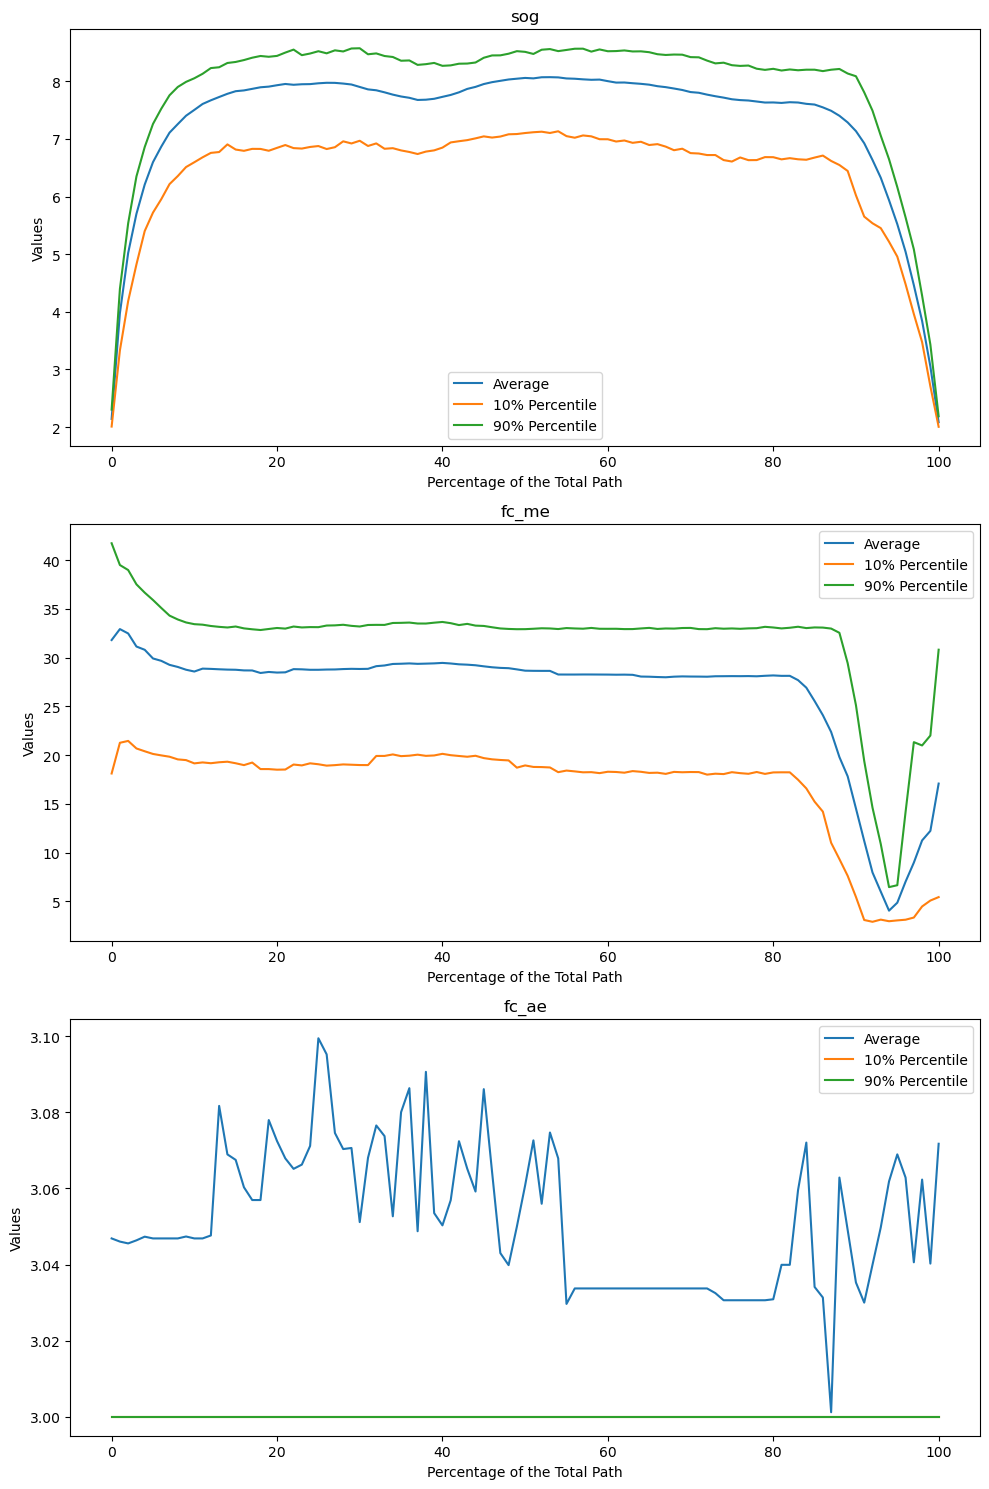

In [343]:
plot_percentiles(trips_0)

In [339]:
trips_0 =[trip for trip,label in zip(trips,labels) if label == 1]
perc = compute_percentiles(trips_0,"sog")
perc

mean  <lambda_0>  <lambda_1>
path_percentage                                  
0                2.142703    2.010000    2.304000
10               7.502091    6.594506    8.050925
20               7.930243    6.843806    8.438869
30               7.900161    6.967051    8.571344
40               7.728650    6.847938    8.266639
50               8.056736    7.101117    8.509019
60               8.000851    6.992942    8.519662
70               7.811621    6.752875    8.417542
80               7.631407    6.681983    8.214780
90               7.134351    6.020652    8.086048
100              2.084865    2.006000    2.188000

In [302]:
paths_0 = [trip["path"] for trip,label in zip(trips,labels) if label == 1]
trips_0 =[trip for trip,label in zip(trips,labels) if label == 1]
rep_0 = generate_representative_path(paths_0)


In [374]:

def find_closest(trip, point):
    index = 0
    max_dist = 1e6
    for i, p in enumerate(trip["path"]):   
        dist = haversine(p, point)
        if dist < max_dist:      
            max_dist = dist
            index = i
    return index


indexes = [find_closest(trips_0[0], rp) for rp in rep_0]
sog = [trips_0[0]["sog"][idx] for idx in indexes]
indexes


[9, 37, 78, 123, 165, 199, 250, 288, 354]

In [507]:
def calculate_distances(path: List[Tuple[float, float]]) -> List[float]:
    distances = []
    current_distance = 0
    for i in range(len(path)):
        if i > 0:
            current_distance = haversine(path[i - 1], path[i])
        distances.append(current_distance)
    return distances


    

In [ ]:
def simplify_trips(trip: List[List[Tuple[float, float]]], epsilon: float = 10):

    # Generate a path representative of all the paths
    r_path = generate_representative_path([trip["path"] for trip in trips])

        
        # Find the indexes closest to the points in the representative path
        indexes = [find_closest(trip, rp) for rp in r_path]
    
        #

        # Summarize
        leg_times = []
        for i in range(len(indexes)):
            if i > 0:
                print(indexes[i-1], indexes[i])
                leg_distances.append(sum(distances[indexes[i-1]+1:indexes[i]]))
    
    return leg_distances, distances

In [510]:

r_path = generate_representative_path(paths_0)
leg_distances = calculate_distances(paths_0[0])

In [490]:
trip = trips_0[0]

In [491]:
indexes = [find_closest(trip, rp) for rp in r_path]

In [509]:
indexes

[9, 37, 78, 123, 165, 199, 250, 288, 354]

In [511]:
leg_times = []
for i in range(len(indexes)):
    if i > 0:
        leg_times.append(trip["timestamp"][indexes[i]] - trip["timestamp"][indexes[i-1]])

# Calculate leg speeds
leg_speeds = [leg_distance / leg_time for leg_time, leg_distance in zip(leg_times, leg_distances)]

In [517]:
(trip["timestamp"][-1] - trip["timestamp"][0]) / 60

5.9

In [303]:

layer = pdk.Layer(
    "PathsLayer",
    to_pydeck(trips_0),
    get_color="color",
    opacity=0.95,
    width_min_pixels=5,
    rounded=True,
    trail_length=6000,
    current_time=1000,
)

layer2 = pdk.Layer(
    "PathLayer",
    to_pydeck([{"path":rep_0}]),
    get_color=[233,0,0],
    opacity=0.95,
    width_min_pixels=5,
    rounded=True,
    trail_length=600,
)
view_state = pdk.ViewState(latitude=59.328565, longitude=18.08059, zoom=13, bearing=0, pitch=0)
r = pdk.Deck(layers=[layer2], initial_view_state=view_state)
r.to_html()



KeyboardInterrupt: 

In [246]:
for trip in data:
    trip["coordinates"] = [item["coordinates"] for item in trip["waypoints"]]
    trip["timestamps"] = [item["timestamp"] - 1554772579000 for item in trip["waypoints"]]
    del trip["waypoints"]


In [264]:
ff = to_pydeck(trips_0)

In [267]:
ff[-1]["relative_timestamp"]

[110831,
 110832,
 110833,
 110834,
 110835,
 110836,
 110837,
 110838,
 110839,
 110840,
 110841,
 110842,
 110843,
 110844,
 110845,
 110846,
 110847,
 110848,
 110849,
 110850,
 110851,
 110852,
 110853,
 110854,
 110855,
 110856,
 110857,
 110858,
 110859,
 110860,
 110861,
 110862,
 110863,
 110864,
 110865,
 110866,
 110867,
 110868,
 110869,
 110870,
 110871,
 110872,
 110873,
 110874,
 110875,
 110876,
 110877,
 110878,
 110879,
 110880,
 110881,
 110882,
 110883,
 110884,
 110885,
 110886,
 110887,
 110888,
 110889,
 110890,
 110891,
 110892,
 110893,
 110894,
 110895,
 110896,
 110897,
 110898,
 110899,
 110900,
 110901,
 110902,
 110903,
 110904,
 110905,
 110906,
 110907,
 110908,
 110909,
 110910,
 110911,
 110912,
 110913,
 110914,
 110915,
 110916,
 110917,
 110918,
 110919,
 110920,
 110921,
 110922,
 110923,
 110924,
 110925,
 110926,
 110927,
 110928,
 110929,
 110930,
 110931,
 110932,
 110933,
 110934,
 110935,
 110936,
 110937,
 110938,
 110939,
 110940,
 110941,
 

In [36]:

#def hex_to_rgb(h):
#    h = h.lstrip("#")
#    return tuple(int(h[i : i + 2], 16) for i in (0, 2, 4))


#df["color"] = df["color"].apply(hex_to_rgb)


view_state = pdk.ViewState(latitude=59.328565, longitude=18.08059, zoom=13)

layer = pdk.Layer(
    type="PathLayer",
    data=trips[0]["coordinates"],
    get_color=[253, 128, 93],
    width_scale=20,
    width_min_pixels=2,
    get_width=5,
)

r = pdk.Deck(layers=[layer], initial_view_state=view_state, tooltip={"text": "{name}"})
r.to_html()

In [24]:
df

name           color  \
0            Richmond - Millbrae   (237, 28, 36)   
1             Fremont - Richmond  (250, 166, 26)   
2      Pittsburg/Bay Point - SFO   (255, 232, 0)   
3  Dublin/Pleasanton - Daly City   (0, 174, 239)   
4            Fremont - Daly City   (77, 184, 72)   

                                                path  
0  [[-122.3535851, 37.9360513], [-122.3179784, 37...  
1  [[-122.353165, 37.936887], [-122.317269, 37.92...  
2  [[-121.945154, 38.018914], [-122.024597, 38.00...  
3  [[-121.900367, 37.701695], [-121.928099, 37.69...  
4  [[-121.9764, 37.557355], [-122.017867, 37.5912...

In [60]:
set_2 = [traj for traj, label in zip(trajectories, labels) if label == 2]

In [61]:
def get_representative_trajectory(trajectories, epsilon):
    paths = [douglas_peucker(get_path(traj), epsilon) for traj in trajectories]
    return [len(path) for path in paths]

In [72]:
def frechet_mean(trajectories):
    """
    Computes the Fréchet mean of a list of trajectories.
    """
    def objective(x):
        # Reshape the 1D parameter array into a 2D trajectory
        traj = [tuple(x[i:i+2]) for i in range(0, len(x), 2)]
        
        # Compute the Fréchet distance between the input trajectories and the current estimate
        dists = [frechet_distance(traj, t) for t in trajectories]
        
        # Compute the weighted average of the input trajectories
        weights = [1/d if d != 0 else float('inf') for d in dists]
        total_weight = sum(weights)
        weighted_pts = [[sum([w * pt[i] for w, d in zip(weights, dists)]) / total_weight for i in range(2)] for pt in traj]
        
        # Return the weighted average trajectory as a 1D array
        return [pt for p in weighted_pts for pt in p]
    
    # Initialize the Fréchet mean to be one of the input trajectories
    mean = trajectories[0]
    
    # Repeat until convergence
    while True:
        print([pt for traj in mean for pt in traj])
        # Optimize the objective function to find the next estimate of the Fréchet mean
        res = minimize(objective, [pt for traj in mean for pt in traj]).x
        traj = [tuple(res[i:i+2]) for i in range(0, len(res), 2)]
        
        # Check for convergence by comparing the Fréchet distance between the current and previous estimates
        dist = frechet_distance(mean, traj)
        if dist < 1e-5:
            break
        
        mean = traj
        
    return mean

In [83]:
def representative_trajectories(trajectories, num_clusters):
    # Convert the list of trajectories into a 2D array
    traj_array = np.array(trajectories).reshape(len(trajectories), -1)

    # Compute pairwise distances between all pairs of trajectories using the Frechet distance
    dists = cdist(traj_array, traj_array, metric=frechet_distance)
    
    # Apply K-means clustering to group similar trajectories together
    kmeans = KMeans(n_clusters=num_clusters)
    labels = kmeans.fit_predict(dists)
    
    # Choose a representative trajectory for each cluster
    centroids = np.zeros((num_clusters, len(trajectories[0]), 2))
    counts = np.zeros(num_clusters)
    for i, traj in enumerate(trajectories):
        centroids[labels[i]] += np.array(traj)
        counts[labels[i]] += 1
    centroids /= counts[:, None]
    
    return [list(map(tuple, traj)) for traj in centroids]

In [86]:
# Convert the list of trajectories into a 2D array
traj_array = np.array([douglas_peucker(get_path(traj), 10) for traj in trajectories]).reshape(len([douglas_peucker(get_path(traj), 10) for traj in trajectories]), -1)
traj_array

/tmp/ipykernel_3581/281012955.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  traj_array = np.array([douglas_peucker(get_path(traj), 10) for traj in trajectories]).reshape(len([douglas_peucker(get_path(traj), 10) for traj in trajectories]), -1)


array([[list([(59.32857, 18.08057), (59.32846, 18.08077), (59.32879, 18.08132), (59.32893, 18.08203), (59.32888, 18.0834), (59.32815, 18.08586), (59.32719, 18.08792), (59.32518, 18.0904), (59.32412, 18.09244), (59.32331, 18.09246), (59.32204, 18.0919), (59.32133, 18.09095), (59.32106, 18.08888), (59.32196, 18.08185), (59.32308, 18.07649), (59.3228, 18.0782), (59.32178, 18.08179), (59.32079, 18.08638), (59.32055, 18.09002), (59.32074, 18.09122), (59.3212, 18.0921), (59.3219, 18.09274), (59.32353, 18.0936), (59.32392, 18.09415)])],
       [list([(59.32395, 18.09421), (59.32386, 18.09283), (59.32503, 18.08961)])],
       [list([(59.32502, 18.08962), (59.32484, 18.09035), (59.32413, 18.09116), (59.32245, 18.09198), (59.32146, 18.09149), (59.32085, 18.09004), (59.32093, 18.08801), (59.3229, 18.07659)])],
       [list([(59.32291, 18.07644), (59.32261, 18.0789), (59.32072, 18.08642), (59.32043, 18.08835), (59.32037, 18.09002), (59.32062, 18.09141), (59.32117, 18.09247), (59.32354, 18.09375), 

In [97]:
time_based_averaging(set_1,60)

TypeError: '>' not supported between instances of 'numpy.ndarray' and 'numpy.ndarray'

In [54]:

TRIPS_LAYER_DATA = "https://raw.githubusercontent.com/visgl/deck.gl-data/master/website/sf.trips.json"  # noqa

df = pd.read_json(TRIPS_LAYER_DATA)

df["coordinates"] = df["waypoints"].apply(lambda f: [item["coordinates"] for item in f])
df["timestamps"] = df["waypoints"].apply(lambda f: [item["timestamp"] - 1554772579000 for item in f])

df.drop(["waypoints"], axis=1, inplace=True)

dd = {
    "coordinates":df["coordinates"].to_list()[0],
    "timestamps":df["timestamps"].to_list()[0]
}

df2 = pd.DataFrame(trips)


layer = pdk.Layer(
    "TripsLayer",
    df,
    get_path="coordinates",
    get_timestamps="timestamps",
    get_color=[253, 128, 93],
    opacity=0.8,
    width_min_pixels=5,
    rounded=True,
    trail_length=600,
    current_time=500,
)

view_state = pdk.ViewState(latitude=59.328565, longitude=18.08059, zoom=11, bearing=0, pitch=45)

# Render
r = pdk.Deck(layers=[layer], initial_view_state=view_state)
r.to_html()

In [55]:
df

coordinates  \
0  [[-122.39079879999997, 37.7664413], [-122.3908...   

                                          timestamps  
0  [0, 9, 54, 92, 345, 402, 462, 563, 880, 1070, ...

In [56]:
df2

coordinates  \
0    [[59.32857, 18.08057], [59.32856, 18.08059], [...   
1    [[59.32395, 18.09421], [59.32394, 18.09419], [...   
2    [[59.32502, 18.08962], [59.32502, 18.08964], [...   
3    [[59.32291, 18.07644], [59.3229, 18.07646], [5...   
4    [[59.3239, 18.09424], [59.3239, 18.09423], [59...   
..                                                 ...   
108  [[59.32295, 18.07645], [59.32294, 18.07647], [...   
109  [[59.32394, 18.09422], [59.32394, 18.0942], [5...   
110  [[59.32499, 18.08953], [59.32497, 18.08953], [...   
111  [[59.32297, 18.07644], [59.32296, 18.07645], [...   
112  [[59.32396, 18.09421], [59.32396, 18.09419], [...   

                                            timestamps  \
0    [[1668939825], [1668939826], [1668939827], [16...   
1    [[1668941915], [1668941916], [1668941917], [16...   
2    [[1668942177], [1668942178], [1668942179], [16...   
3    [[1668942976], [1668942977], [1668942978], [16...   
4    [[1668943738], [1668943739], [1668943740], [16...   
..                                                 ...   
108  [[1669052160], [1669052161], [1669052162], [16...   
109  [[1669052806], [1669052807], [1669052808], [16...   
110  [[1669053008], [1669053009], [1669053010], [16...   
111  [[1669053610], [1669053611], [1669053612], [16...   
112  [[1669053991], [1669053992], [1669053993], [16...   

                                            attributes  
0    {'fc_ae': [4.01817, 3.61628, 3.58758, 3.58758,...  
1    {'fc_ae': [2.99999, 2.99999, 2.99999, 2.99999,...  
2    {'fc_ae': [2.99999, 2.99999, 2.99999, 2.99999,...  
3    {'fc_ae': [2.99999, 2.99999, 2.99999, 2.99999,...  
4    {'fc_ae': [2.99999, 2.99999, 2.99999, 2.99999,...  
..                                                 ...  
108  {'fc_ae': [2.99999, 2.99999, 2.99999, 2.99999,...  
109  {'fc_ae': [2.99999, 2.99999, 2.99999, 2.99999,...  
110  {'fc_ae': [2.99999, 2.99999, 2.99999, 2.99999,...  
111  {'fc_ae': [2.99999, 2.99999, 2.99999, 2.99999,...  
112  {'fc_ae': [2.99999, 2.99999, 2.99999, 2.99999,...  

[113 rows x 3 columns]

In [ ]:
# Draw trajectories from time-grouped messages and segment them
# by basic behaviours
for group in grouped_messages:
    subset = group[['lon', 'lat', 'timestamp']]
    trajectory = [tuple(x) for x in subset.

In [9]:
df.rename(columns = {
    "Timestamp [UTC]":"timestamp",
    "Speed over ground (kts)":"sog_kts",
    "Consumption ME (L/h)": "fuel_consumption_main_engines",
    "Consumption AE (L/h)": "fuel_consumption_auxiliary_engines",
    "Latitude (deg)": "latitude",
    "Longitude (deg)": "longitude"
}, inplace = True)

In [55]:
trajectories[-1][0]

(Timestamp('2022-11-21 18:00:07+0000', tz='UTC'), 59.32297, 18.07639, 1.01, 42.3, 2.99999, 240000000000)

In [56]:
# Remove 
trajectories[-1][-1]

(Timestamp('2022-11-21 18:11:22+0000', tz='UTC'), 59.32863, 18.08058, 1.26, 27.7, 2.99999, 0)

In [57]:
trajectories[-1]

[(Timestamp('2022-11-21 18:00:07+0000', tz='UTC'), 59.32297, 18.07639, 1.01, 42.3, 2.99999, 240000000000),
 (Timestamp('2022-11-21 18:00:08+0000', tz='UTC'), 59.32297, 18.0764, 1.37, 42.1, 2.99999, 0),
 (Timestamp('2022-11-21 18:00:09+0000', tz='UTC'), 59.32297, 18.07642, 1.77, 41.3, 2.99999, 0),
 (Timestamp('2022-11-21 18:00:10+0000', tz='UTC'), 59.32297, 18.07644, 2.17, 40.7, 2.99999, 0),
 (Timestamp('2022-11-21 18:00:11+0000', tz='UTC'), 59.32296, 18.07645, 2.62, 40., 2.99999, 0),
 (Timestamp('2022-11-21 18:00:12+0000', tz='UTC'), 59.32296, 18.07648, 2.89, 39.7, 2.99999, 0),
 (Timestamp('2022-11-21 18:00:13+0000', tz='UTC'), 59.32296, 18.07651, 3.3, 39.4, 2.99999, 0),
 (Timestamp('2022-11-21 18:00:14+0000', tz='UTC'), 59.32295, 18.07653, 3.56, 39.1, 2.99999, 0),
 (Timestamp('2022-11-21 18:00:15+0000', tz='UTC'), 59.32295, 18.07657, 3.77, 39.1, 2.99999, 0),
 (Timestamp('2022-11-21 18:00:16+0000', tz='UTC'), 59.32294, 18.0766, 4.13, 38.8, 2.99999, 0),
 (Timestamp('2022-11-21 18:00:17+